## 1 - Installs and imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import generic wrappers
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from scipy.special import softmax
from collections import defaultdict
import torch
import urllib
from sklearn.metrics import classification_report

## 2 - Load the model and the tokenizer

In [ ]:
# Define the model repo
model_name = "monsoon-nlp/hindi-bert" 
#model_name = "monsoon-nlp/hindi-tpu-electra"

# Download pytorch model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

loading configuration file https://huggingface.co/monsoon-nlp/hindi-bert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/00bed33c80b13c0d6e5faaaf0d282897260f96fa0c130820a14793a4647acbe6.5cdbeb7c10601520e5786b645995f3c8b281e9136dfee228ee2b706379153238
Model config ElectraConfig {
  "_name_or_path": "monsoon-nlp/hindi-bert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activa

## 3 - Define training parameters 

In [ ]:
LR = 2e-5
EPOCHS = 3
BATCH_SIZE = 8
MAX_TRAINING_EXAMPLES = -1 # set this to -1 if you want to use the whole training set

## 4 - Load UMSAB dataset (for fine-tuning)

In [ ]:
files = """test_labels.txt
test_text.txt
train_labels.txt
train_text.txt
val_labels.txt
val_text.txt""".split('\n')

In [ ]:
def fetch_data(language, files):
 dataset = defaultdict(list)
 for infile in files:
   thisdata = infile.split('/')[-1].replace('.txt','')
   dataset_url = f"https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/{language}/{infile}"
   print(f'Fetching from {dataset_url}')
   with urllib.request.urlopen(dataset_url) as f:
     for line in f:
       if thisdata.endswith('labels'):
         dataset[thisdata].append(int(line.strip().decode('utf-8')))
       else:
         dataset[thisdata].append(line.strip().decode('utf-8'))
 return dataset

In [ ]:
# Load the Hindi dataset
umsab_dataset = fetch_data('hindi', files)

Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/test_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/test_text.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/train_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/train_text.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/val_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/val_text.txt


In [ ]:
train_text = umsab_dataset ['train_text']
train_labels = umsab_dataset ['train_labels']

val_text = umsab_dataset ['val_text']
val_labels = umsab_dataset ['val_labels']

test_text = umsab_dataset ['test_text']
test_labels = umsab_dataset ['test_labels']

## 5 - Encoding the datasets

In [ ]:
train_encodings = tokenizer(train_text, truncation=True, padding=True)
val_encodings = tokenizer(val_text, truncation=True, padding=True)
test_encodings = tokenizer(test_text, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings,train_labels)
val_dataset = MyDataset(val_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

## 6 - Fine-tuning the model

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',                   # output directory
    num_train_epochs=EPOCHS,                  # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=100,                         # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                        # strength of weight decay
    logging_dir='./logs',                     # directory for storing logs
    logging_steps=10,                         # when to print log
    load_best_model_at_end=True,              # load or not best model at the end
    evaluation_strategy = "no",               # provided in order the evaluation and save strategy to match
    save_strategy = 'no'
)

num_labels = len(train_labels)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,                              # the instantiated 🤗 Transformers model to be trained
    args=training_args,                       # training arguments, defined above
    train_dataset=train_dataset,              # training dataset
    eval_dataset=val_dataset                  # evaluation dataset
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1839
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 690


Step,Training Loss
10,1.101900
20,1.095600
30,1.108900
40,1.104200
50,1.095800
60,1.095900
70,1.098500
80,1.100700
90,1.099200
100,1.099400




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=690, training_loss=1.0989630975585052, metrics={'train_runtime': 3453.7742, 'train_samples_per_second': 1.597, 'train_steps_per_second': 0.2, 'total_flos': 112857920004456.0, 'train_loss': 1.0989630975585052, 'epoch': 3.0})

Save the trained model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

trainer.save_model("/content/gdrive/My Drive/Models") # save best model

Saving model checkpoint to /content/gdrive/My Drive/Models
Configuration saved in /content/gdrive/My Drive/Models/config.json


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Model weights saved in /content/gdrive/My Drive/Models/pytorch_model.bin


## 7 - Evaluation of the fine-tuned model on UMSAB test dataset

In [ ]:
test_preds_raw, test_labels , _ = trainer.predict(test_dataset)
test_preds = np.argmax(test_preds_raw, axis=-1)
print(classification_report(test_labels, test_preds, digits=3))

***** Running Prediction *****
  Num examples = 870
  Batch size = 8


              precision    recall  f1-score   support

           0      0.389     0.328     0.356       290
           1      0.437     0.397     0.416       290
           2      0.344     0.431     0.383       290

    accuracy                          0.385       870
   macro avg      0.390     0.385     0.385       870
weighted avg      0.390     0.385     0.385       870



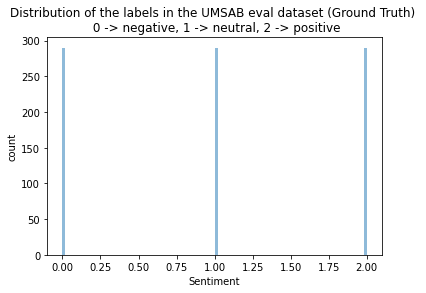

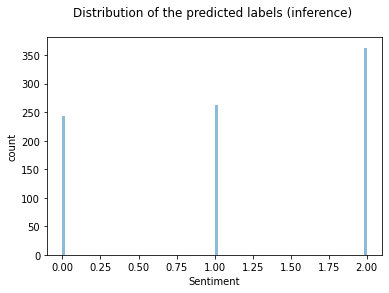

In [ ]:
plt.figure()
plt.hist(test_labels, bins=100, alpha=0.5)
plt.title('Distribution of the labels in the UMSAB eval dataset (Ground Truth) \n 0 -> negative, 1 -> neutral, 2 -> positive')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.show()

plt.figure()
plt.hist(test_preds, bins=100, alpha=0.5)
plt.title('Distribution of the predicted labels (inference) \n ')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.show()